In [25]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [26]:
series = pd.read_csv('sine-wave.csv', header=None ) #leitura do arquivo execel variação de 1 a -1, onda senoidal simples.

In [27]:
series.head()

,0
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [28]:
series.shape #amostra com 5k1 linhas e 1 coluna

(5001, 1)

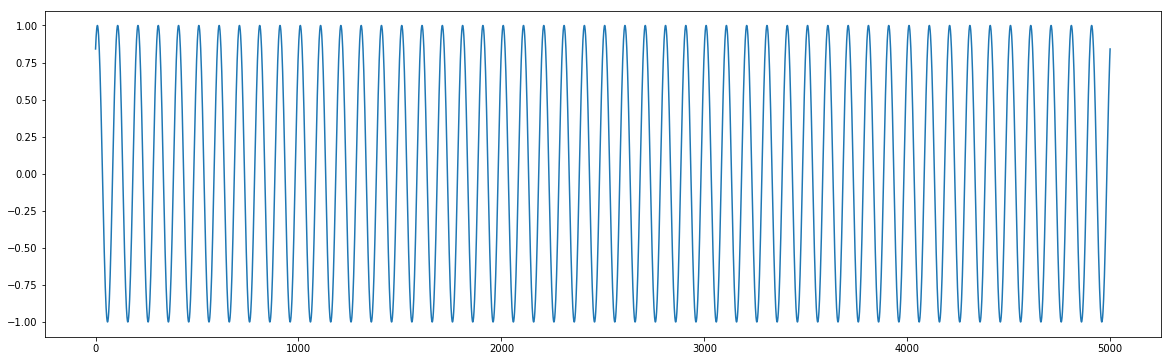

In [29]:
#poltando a senoide
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

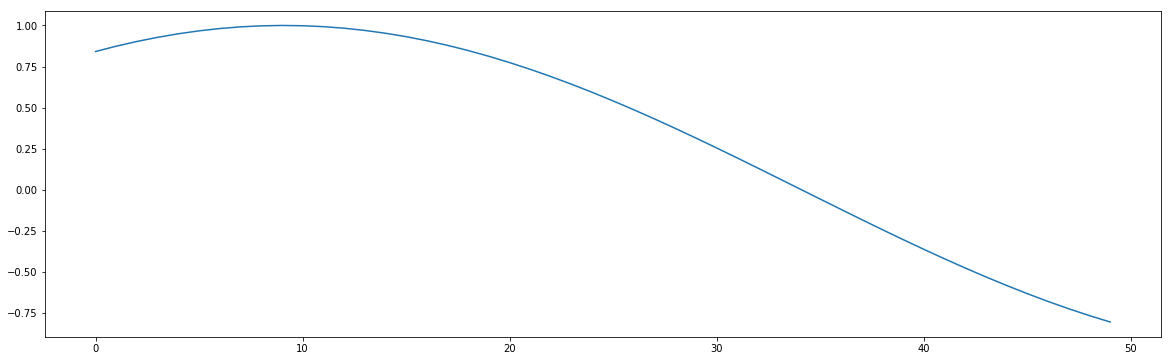

In [30]:
#selecionando as primeiras 50 amostras, Amplitude de 1
#aprenda a onda do pecado a partir de um tamanho de 
#janela de conjunto de dados que iremos alimentá-lo
#e esperamos poder pedir ao LSTM que preveja os próximos N passos da série e ele continuará cuspindo o pecado onda.
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:50])
pyplot.show()

In [31]:
#Normalizando os dados usando o minmax scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

In [32]:
#Fixe o tamanho da janela móvel em 50. 
#Usar a função pandas shift, 
#que desloca a coluna inteira pelo número que especificamos.
#No trecho de código abaixo, é aumentando a coluna em 1 (portanto, usamos -1. Se quisermos alterá- la em 1, teremos que usar +1)
#e então concatenar isso com os dados originais.
window_size = 50
series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [33]:
#O segundo elemento de cada coluna é o primeiro da proxima coluna, mas só para os primeiros 50 termos
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.841483,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,...,-0.420975,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483
1,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,...,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749
2,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,...,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566
3,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,...,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822
4,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,0.969904,...,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416


In [34]:
series.shape

(4951, 51)

In [35]:
#pega a quantidade de linhas * 0.8 = pega 80% pra treino e o resto pra teste
nrow = round(0.8*series.shape[0])
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]

In [36]:
#Alinhamentos aleatórios ou matrizes esparsas de maneira consistente. Usado em 
from sklearn.utils import shuffle
train = shuffle(train)

In [37]:
train

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2070,-0.773898,-0.732603,-0.688418,-0.641515,-0.592081,-0.540310,-0.486407,-0.430584,-0.373061,-0.314067,...,0.992780,0.983282,0.969904,0.952697,0.931731,0.907088,0.878865,0.847173,0.812138,0.773898
3806,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,0.969904,0.952697,0.931731,...,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416,-0.967263,-0.981292
1646,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416,-0.967263,...,0.182166,0.243547,0.303967,0.363188,0.420975,0.477101,0.531344,0.583490,0.633333,0.680677
335,-0.057491,-0.120065,-0.182166,-0.243547,-0.303967,-0.363188,-0.420975,-0.477101,-0.531344,-0.583490,...,-0.486407,-0.430584,-0.373061,-0.314067,-0.253833,-0.192597,-0.130601,-0.068090,-0.005310,0.057491
1125,0.540310,0.486407,0.430584,0.373061,0.314067,0.253833,0.192597,0.130601,0.068090,0.005310,...,-0.907088,-0.878865,-0.847173,-0.812138,-0.773898,-0.732603,-0.688418,-0.641515,-0.592081,-0.540310
84,-0.005310,0.057491,0.120065,0.182166,0.243547,0.303967,0.363188,0.420975,0.477101,0.531344,...,0.540310,0.486407,0.430584,0.373061,0.314067,0.253833,0.192597,0.130601,0.068090,0.005310
716,0.907088,0.878865,0.847173,0.812138,0.773898,0.732603,0.688418,0.641515,0.592081,0.540310,...,-0.991449,-0.997693,-1.000000,-0.998360,-0.992780,-0.983282,-0.969904,-0.952697,-0.931731,-0.907088
2027,0.430584,0.373061,0.314067,0.253833,0.192597,0.130601,0.068090,0.005310,-0.057491,-0.120065,...,-0.847173,-0.812138,-0.773898,-0.732603,-0.688418,-0.641515,-0.592081,-0.540310,-0.486407,-0.430584
2020,0.773898,0.732603,0.688418,0.641515,0.592081,0.540310,0.486407,0.430584,0.373061,0.314067,...,-0.992780,-0.983282,-0.969904,-0.952697,-0.931731,-0.907088,-0.878865,-0.847173,-0.812138,-0.773898
723,0.641515,0.592081,0.540310,0.486407,0.430584,0.373061,0.314067,0.253833,0.192597,0.130601,...,-0.952697,-0.931731,-0.907088,-0.878865,-0.847173,-0.812138,-0.773898,-0.732603,-0.688418,-0.641515


In [38]:
#separa x,y, dado do resultado
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [39]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [40]:
#train_X.shape
#train_y.shape
#test_X.shape
test_y.shape

(990,)

In [41]:
#Dá uma nova forma a uma matriz sem alterar seus dados.
#numpy.shape(linha x coluna)
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1) #( linha do train_X, coluna train_X, 1 ) cria um Array3D
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [18]:
train_X.shape
#train_y.shape
#test_X.shape
#test_y.shape

(3961, 50, 1)

In [42]:
# Definicao do modelo LSTM
# estrutura de rede de [1, 50, 256, 1] onde temos 1 camada de entrada (50,1) 
# (consistindo de uma seqüência de tamanho 50) 
# que alimenta uma camada LSTM com 50 neurônios, 
# que por sua vez alimenta outra camada LSTM com 256 neurônios 
# que então se alimentam em uma camada normal 
# totalmente conectada de 1 neurônio [Dense(1)] 
# com uma função de ativação linear 
# que será usada para dar a previsão do próximo passo de tempo.
model = Sequential()
model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [43]:
start = time.time()
#aqui fita, ou melhor treina o modelo para predizer os resultados... blocos de 512 com 3 épocas
model.fit(train_X,train_y,batch_size=512,nb_epoch=3,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 3564 samples, validate on 397 samples
Epoch 1/3
3564/3564 [==============================] - 7s 2ms/step - loss: 0.2281 - val_loss: 0.0708
Epoch 2/3
3564/3564 [==============================] - 5s 2ms/step - loss: 0.0471 - val_loss: 0.0057
Epoch 3/3
3564/3564 [==============================] - 6s 2ms/step - loss: 0.0217 - val_loss: 0.0021
> Compilation Time :  19.088491439819336


In [44]:
# aqui está predizendo,
preds = model.predict(test_X)

In [45]:
#preds = scaler.inverse_transform(preds)
#actuals = scaler.inverse_transform(test_y)
actuals = test_y

In [46]:
mean_squared_error(actuals,preds)

0.0020757252996834417

Text(0.5,1,'Modelo a comparar')

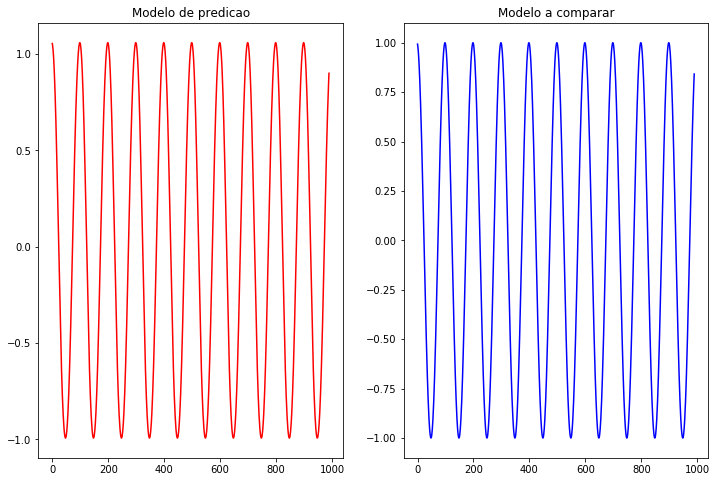

In [47]:
fig, ax = pyplot.subplots(1,2, figsize=(12,8))
ax[0].plot(preds,'r-')
titulo = 'Modelo de predicao'
ax[0].set_title(titulo)

ax[1].plot(actuals,'b-')
titulo = 'Modelo a comparar'
ax[1].set_title(titulo)

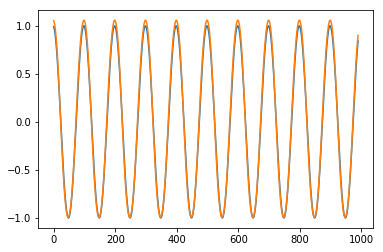

In [48]:
pyplot.plot(actuals)
pyplot.plot(preds)
pyplot.show()

In [61]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving
        

In [64]:
#preds = scaler.inverse_transform(preds)
#actuals = scaler.inverse_transform(test_y)
preds_moving = moving_test_window_preds(500)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.05374002  1.04986644  1.04630947  1.04284954  1.03914666  1.0348438
  1.02962244  1.02322567  1.01546121  1.00619459  0.9953385   0.98283988
  0.96866977  0.95281458  0.93526864  0.91603035  0.89509779  0.87246668
  0.84812963  0.82207453  0.79428601  0.76474488  0.73342919  0.70031506
  0.66537684  0.62858826  0.58992279  0.54935426  0.50685763  0.46241075
  0.41599503  0.3675974   0.317213    0.26484624  0.21051376  0.15424648
  0.09609223  0.03611876 -0.02558356 -0.08889768 -0.15367658 -0.21973948
 -0.28686821 -0.35480449 -0.42324784 -0.49185529 -0.56024128 -0.62798131
 -0.69461519 -0.75965416 -0.82258838 -0.88313878 -0.94054586 -0.99431044
 -1.04395437 -1.08903146 -1.12913692 -1.16391683 -1.19307494 -1.21637845
 -1.23365879 -1.24481177 -1.24979401 -1.24861765 -1.24134326 -1.22807276
 -1.20894039 -1.18410313 -1.15373397 -1.11801434 -1.07712638 -1.03124774
 -0.98054743 -0.92518187 -0.86529225 -0.80100375 -0.73242533 -0.65964979
 -0.5827561  -0.50181222 -0.41687953 -0.328017   -0.23528923 -0.13877288
 -0.03856703  0.06519733  0.17234504  0.28264531  0.39579961  0.51143086
  0.62907463  0.74817425  0.86808038  0.98805749  1.10729647  1.22493422
  1.34008026  1.45184767  1.55938673  1.66191614  1.7587539   1.84934044
  1.93325591  2.01022315  2.0801115   2.14292479  2.19879007  2.24793506
  2.29067254  2.32737494  2.35845661  2.38435555  2.40551639  2.42237949
  2.43536925  2.44488883  2.4513123   2.45498443  2.456218    2.45529461
  2.45246482  2.4479506   2.44194651  2.43462229  2.42612696  2.41658711
  2.40611315  2.39480066  2.38273048  2.36997175  2.35658526  2.34262133
  2.32812452  2.31313157  2.29767632  2.28178501  2.26548219  2.2487874
  2.23171639  2.21428323  2.19649792  2.17836833  2.15989947  2.14109492
  2.12195492  2.10247946  2.08266497  2.06250763  2.04200172  2.02113986
  1.9999131   1.9783113   1.95632315  1.93393576  1.91113508  1.88790452
  1.86422753  1.84008503  1.81545746  1.79032218  1.76465619  1.73843467
  1.71163046  1.68421543  1.6561588   1.62742865  1.59799016  1.56780672
  1.5368402   1.50504887  1.47238934  1.43881559  1.40427852  1.36872661
  1.33210516  1.29435623  1.25541914  1.21522975  1.17372072  1.13082111
  1.08645713  1.0405513   0.99302346  0.9437905   0.89276677  0.83986503
  0.78499651  0.72807246  0.66900539  0.60771     0.54410589  0.47811958
  0.40968817  0.33876213  0.26531041  0.18932477  0.11082658  0.02987269
 -0.05343711 -0.1389523  -0.22646369 -0.31569564 -0.40629908 -0.49784598
 -0.58982605 -0.68164676 -0.77263659 -0.86205363 -0.94909966 -1.03293777
 -1.11271513 -1.18759012 -1.25675833 -1.31948125 -1.37510943 -1.42310333
 -1.46304572 -1.49465096 -1.51776099 -1.53234196 -1.53846979 -1.53631461
 -1.52612269 -1.50819576 -1.48287332 -1.45051515 -1.411484   -1.36613441
 -1.31480122 -1.25779188 -1.19538081 -1.12780488 -1.05526304 -0.97791493
 -0.89588237 -0.80925232 -0.71808028 -0.62239522 -0.52220649 -0.41751242
 -0.30831006 -0.19460821 -0.07644255  0.04610688  0.17289551  0.30369237
  0.4381575   0.57582122  0.7160666   0.85811853  1.00104415  1.14376426
  1.28508008  1.42371476  1.55836582  1.68776357  1.81073463  1.92625654
  2.03350234  2.13187122  2.22100019  2.30075812  2.37122893  2.43268275
  2.48553777  2.5303266   2.56765532  2.59817266  2.62254286  2.64141893
  2.65543008  2.66516376  2.67116284  2.67391872  2.67387176  2.67140913
  2.66687131  2.66055298  2.65270782  2.64355326  2.63327336  2.62202549
  2.60994029  2.59712911  2.58368373  2.56968164  2.5551877   2.54025555
  2.52492952  2.50924945  2.49324679  2.47695065  2.46038342  2.44356704
  2.42651796  2.40925074  2.39177728  2.37410617  2.35624409  2.33819532
  2.31996202  2.30154419  2.28294086  2.26414967  2.24516702  2.2259872
  2.20660543  2.18701482  2.16720724  2.14717436  2.12690735  2.10639548
  2.08562803  2.0645926   2.04327607  2.0216651   1.99974358  1.97749674
  1.9549073   1.93195736  1.90862799  1.88489902  1.86074984  1.83615756
  1.81109846  1.78554869  1.75948107  1.73286831  1.70568109  1.67788839
  1.64945829  1.62035537  1.5905441   1.55998588  1.52864015  1.49646366
  1.46341157  1.42943609  1.39448631  1.35850942  1.32144892  1.28324544
  1.24383676  1.20315731  1.16113806  1.11770678  1.07278788  1.02630317
  0.97817075  0.92830658  0.87662387  0.8230347   0.76745003  0.70978057
  0.6499393   0.58784199  0.52341002  0.45657265  0.38727045  0.31545925
  0.24111453  0.16423705  0.08485855  0.003049   -0.08107608 -0.16734788
 -0.25553611 -0.34534168 -0.43638968 -0.52822489 -0.62030917 -0.71202224
 -0.80266756 -0.89148194 -0.97765017 -1.0603267  -1.13865781 -1.2118094
 -1.27899528 -1.3395021  -1.39271402 -1.43813026 -1.47537661 -1.50420988
 -1.52451396 -1.53629375 -1.53965843 -1.53480697 -1.52200663 -1.50157452
 -1.47385967 -1.43922544 -1.39803338 -1.35063362 -1.29735339 -1.23848999
 -1.17430615 -1.10502672 -1.03083742 -0.9518854  -0.86828083 -0.78009951
 -0.68738729 -0.59016579 -0.48843962 -0.38220492 -0.27146101 -0.15622331
 -0.03653999  0.08749031  0.21569687  0.34781519  0.48346472  0.62212813
  0.76313645  0.90566111  1.04871786  1.19118273  1.33182466  1.46935081
  1.60246098  1.72990942  1.85056615  1.96346831  2.06786108  2.16322184
  2.24926543  2.32593679  2.39338398  2.45193291  2.50204349  2.54427791
  2.57926154  2.60765147  2.63011098  2.64728737  2.65979815  2.66821694
  2.67307043  2.67483282  2.67392707  2.67072463  2.66555047  2.65868545
  2.65037012  2.64081144  2.63018298  2.61863327  2.60628676  2.5932467
  2.57960081  2.5654223   2.55077052  2.53569722  2.5202446   2.50444961
  2.48834252  2.47194982  2.45529485  2.43839669  2.42127156  2.40393353
  2.38639235  2.3686564   2.35073137  2.3326211   2.314327    2.29584861
  2.27718472  2.25833178  2.23928618  2.22004223  2.2005949   2.18093562
  2.16105819  2.14095235  2.12060976  2.10001874  2.07916856  2.05804682
  2.03663993  2.01493359  1.99291313  1.97056139  1.94786179  1.92479622
  1.90134537  1.87748861  1.85320401  1.82846975  1.80326164  1.77755451
  1.75132084  1.72453356  1.69716275  1.66917646  1.64054179  1.61122382
  1.58118594  1.55038846].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

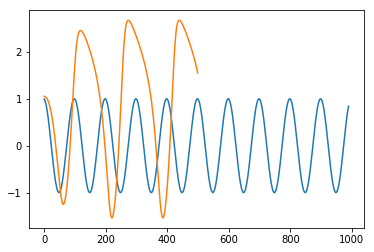

In [60]:
pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()